In [9]:
import random

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from sktime.utils.plotting import plot_series
from tensorflow.keras import layers, models, regularizers
from sklearn.metrics import r2_score



SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

df = pd.read_csv("data/us_change.csv", index_col=0)
df

,Quarter,Consumption,Income,Production,Savings,Unemployment
1,1970 Q1,0.618566,1.044801,-2.452486,5.299014,0.9
2,1970 Q2,0.451984,1.225647,-0.551459,7.789894,0.5
3,1970 Q3,0.872872,1.585154,-0.358652,7.403984,0.5
4,1970 Q4,-0.271848,-0.239545,-2.185691,1.169898,0.7
5,1971 Q1,1.901345,1.975925,1.909764,3.535667,-0.1
...,...,...,...,...,...,...
194,2018 Q2,0.983112,0.661825,1.117424,-2.723974,0.0
195,2018 Q3,0.853181,0.806271,1.256722,-0.085686,-0.3
196,2018 Q4,0.356512,0.695142,0.948148,5.031337,0.2
197,2019 Q1,0.282885,1.100753,-0.488206,9.760287,-0.1


In [2]:
def convert_to_period(quarter):
    """
    Function to convert a string to a pandas period object. 
    Checks if the input is a string in the form '2019 Q1' or already a Period.
    """
    if len(quarter)==2:
        return quarter
    year, quarter_str = quarter.split()
    return quarter_str

df['Quarter'] = df['Quarter'].apply(convert_to_period)

In [4]:
sequence_length = 4  # Número de trimestres na janela de tempo
test_size = 0.2
val_size = 0.2
target_column = 'Consumption'


feature_columns = [col for col in df.columns if col not in ['Quarter', target_column]]
preprocessor = ColumnTransformer(
    transformers=[
        ('quarter', OneHotEncoder(drop='first', sparse_output=False), ['Quarter']),
        ('num', MinMaxScaler(), feature_columns),
        ('target', MinMaxScaler(), [target_column]),
    ]
)

scaled_data = preprocessor.fit_transform(df[['Income', 'Production', 'Savings', 'Unemployment', "Quarter", "Consumption"]])
# scaled_data = np.concatenate([scaled_data, df['Quarter'].values.reshape(-1, 1)], axis=1)

def create_sequences(data, target_idx, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, :-1])
        y.append(data[i + seq_length, target_idx])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, target_idx=-1, seq_length=sequence_length)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_size, random_state=42)

inputs = layers.Input(shape=(sequence_length, X.shape[2]))

x = layers.Conv1D(4, 2, activation="leaky_relu", kernel_regularizer=regularizers.l2(0.001), padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(2, padding='same')(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv1D(4, 2, activation="leaky_relu", kernel_regularizer=regularizers.l2(0.001), padding='same')(x)
x = layers.BatchNormalization()(x)

x = layers.Dropout(0.2)(x)

x = layers.Conv1D(4, 2, activation="leaky_relu", kernel_regularizer=regularizers.l2(0.001), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling1D()(x)  

outputs = layers.Dense(1, kernel_regularizer=regularizers.l2(0.001))(x)
model = models.Model(inputs, outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4, 7)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 4, 4)           │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 4)           │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2, 4)           │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2, 4)           │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 2, 4)           │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 4)           │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 4)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185 (740.00 B)

 Trainable params: 161 (644.00 B)

 Non-trainable params: 24 (96.00 B)

In [5]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)


test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - loss: 0.9267 - mae: 0.8446 - val_loss: 0.4578 - val_mae: 0.6511
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.8380 - mae: 0.8006 - val_loss: 0.4430 - val_mae: 0.6394
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7396 - mae: 0.7519 - val_loss: 0.4291 - val_mae: 0.6283
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7167 - mae: 0.7203 - val_loss: 0.4130 - val_mae: 0.6151
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6730 - mae: 0.7034 - val_loss: 0.3959 - val_mae: 0.6007
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6634 - mae: 0.6965 - val_loss: 0.3782 - val_mae: 0.5855
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6470 - mae: 0.6954 - val_loss: 0.3639 - val_mae: 0.5730
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5509 - mae: 0.6310 - val_loss: 0.3505 - val_mae: 0.5610
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5194 - mae: 0.6144 -

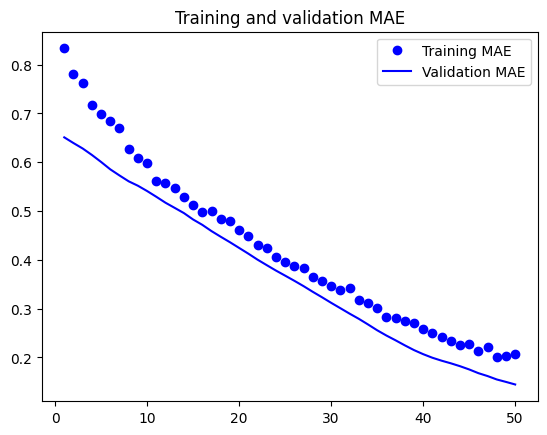

In [6]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Train, Test and Predictions'}, ylabel='y_train'>)

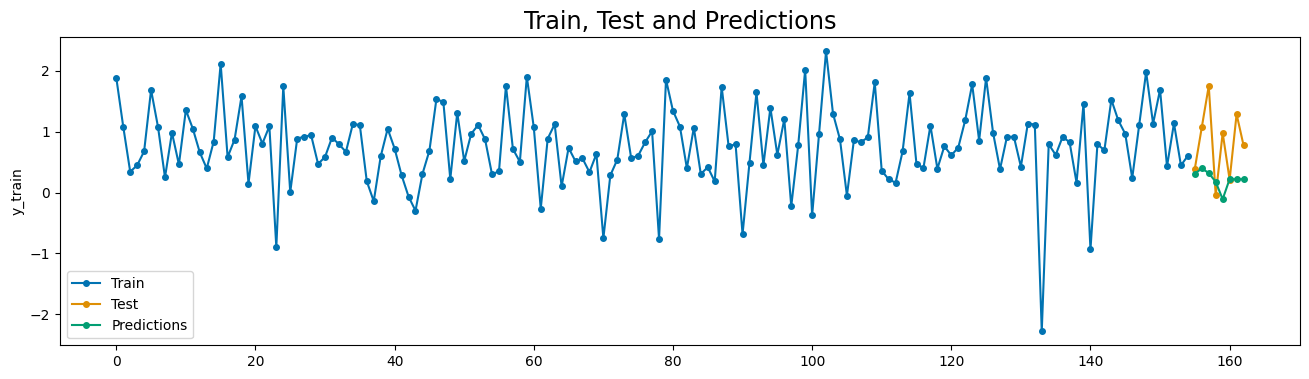

In [ ]:
df_plot = pd.DataFrame()
df_plot.index = range(len(y_train) + len(y_test))

y_pred = model.predict(X_test)
y_train_inverse = preprocessor["target"].inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_inverse = preprocessor["target"].inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inverse = preprocessor["target"].inverse_transform(y_pred.reshape(-1, 1)).flatten()



df_plot["y_train"] = np.nan
df_plot["y_test"] = np.nan
df_plot["y_pred"] = np.nan
df_plot.loc[:len(y_train)-1, "y_train"] = y_train_inverse
df_plot.loc[len(y_train):, "y_test"] = y_test_inverse
df_plot.loc[len(y_train):, "y_pred"] = y_pred_inverse


plot_series(
    df_plot["y_train"],
    df_plot["y_test"],
    df_plot["y_pred"],
    labels=["Train", "Test", "Predictions"],
    title="Train, Test and Predictions",
)

In [11]:
mae = mean_absolute_error(y_test_inverse, df_plot.loc[len(y_train_inverse):, "y_pred"])
rmse = np.sqrt(mean_squared_error(y_test_inverse, df_plot.loc[len(y_train_inverse):, "y_pred"]))

# MASE
naive_forecast = np.roll(y_train_inverse, 1)
naive_forecast[0] = y_train_inverse[0]
mae_naive = mean_absolute_error(y_train_inverse, naive_forecast)
mase = mae / mae_naive
r2 = r2_score(y_test_inverse, y_pred_inverse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Scaled Error (MASE): {mase}")
print(f"R2 Score: {r2}")

Mean Absolute Error (MAE): 0.6410503839044386
Root Mean Squared Error (RMSE): 0.805335535530547
Mean Absolute Scaled Error (MASE): 0.879835816825898
R2 Score: -1.0983297590569912
